# 2x Single-Image Super-Resolution on Grayscale Images

**Assignment:** Individual Class Project<br>
**Author:** Richard Hemphill<br>
**ID:** 903877709<br>
**Class:** ECE5268 Theory of Neural Networks<br>
**Instructor:** Dr. Georgios C. Anagnostopoulos<br>
**Description:** Using small-sized grayscale images, construct a CNN-based architecture that will downscale (magnify) the images by a factor of 2.<br>
**Emphasis:** Describe the concept of single-image super-resolution, describe the architecture in sufficient detail and show indicative training and post-training results.<br>


**References:**
* https://www.kaggle.com/spaceengineer1/alexonly-greyscale
* https://www.kaggle.com/c/two-sigma-financial-news/discussion/83593
* https://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html

In [556]:
# Imports
import os.path
import math
import random
import shutil
import glob
import PIL
from IPython.display import display
from pathlib import Path
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from kaggle.api.kaggle_api_extended import KaggleApi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.python.client import device_lib

In [557]:
# Constants
CURRENT_DIRECTORY = '.'
TEMP_DIRECTORY = './tmp/'
RANDRANGE_STOP = 10000
EPOCHS = 2
BATCH_SIZE = 10
IMAGE_SET_OWNER = 'spaceengineer1'
IMAGE_SET_FILE = 'alexonly-greyscale'
ZIP_EXTENSION = 'zip'
IMAGE_EXTENSION = 'jpg'
PROCESSED_IMAGE_FOLDER ='dataSet'
TRAIN_FOLDER = 'train'
TEST_FOLDER = 'test'
RESCALE_FACTOR = 255.0
VALIDATION_SPLIT = 0.2
CHANNELS = 1
ORIG_IMG_SIZE = 64
UPSCALE_FACTOR = 2
LOW_RES_IMG_SIZE = int(ORIG_IMG_SIZE/UPSCALE_FACTOR)

In [558]:
# Check if Tensorflow is using GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


## Prepocessing

In [559]:
# Extract raw image set
def DownloadImageSet(imageSetOwner = IMAGE_SET_OWNER, imageSetFile = IMAGE_SET_FILE):
    zipFile = '{}.{}'.format(imageSetFile, ZIP_EXTENSION)
    if not os.path.isfile(zipFile):
        # connect to the Kaggle Database and download dataset
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files('{}/{}'.format(imageSetOwner, imageSetFile))
    # extract the dataset
    zf = ZipFile(zipFile)
    topDir = ''.join({item.split('/')[0] for item in zf.namelist()})
    if not os.path.isdir(topDir):
        zf.extractall() 
        zf.close()

    testDirPre = os.path.join(topDir,TEST_FOLDER)
    if os.path.isdir(testDirPre):
        if not os.path.isdir(TEST_FOLDER):
            shutil.move(testDirPre, CURRENT_DIRECTORY)
        
    return topDir, TEST_FOLDER

In [560]:
# Pre Process Images
trainFolder, testFolder = DownloadImageSet()

In [561]:
testImgPaths = glob.glob('{}/*.{}'.format(testFolder, IMAGE_EXTENSION))

In [562]:
def ImageNorm(image):
    image = image/RESCALE_FACTOR
    return image

In [563]:
def Shrink(input):
    return tf.image.resize(input,[LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE],method='area')

In [564]:
trainSet = image_dataset_from_directory(
    directory=trainFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='training',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 644 files for training.


In [565]:
trainSet = trainSet.map(ImageNorm)
trainSet = trainSet.map(lambda x: (Shrink(x),x))

In [566]:
valSet = image_dataset_from_directory(
    directory=trainFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 160 files for validation.


In [567]:
valSet = valSet.map(ImageNorm)
valSet = valSet.map(lambda x: (Shrink(x),x))

## Utility Functions

In [568]:
def MagnifyImage(model, lowResImg):
    lowResArr = img_to_array(lowResImg)
    lowResArr = lowResArr.astype('float32')/RESCALE_FACTOR
    lowResArr = np.expand_dims(lowResArr, axis=0)
    hiResArr = model.predict(lowResArr)
    hiResArr *= RESCALE_FACTOR
    hiResArr = hiResArr.reshape((ORIG_IMG_SIZE,ORIG_IMG_SIZE,CHANNELS))
    hiResImg = array_to_img(hiResArr)
    return hiResImg

In [569]:
class SuperCallback(keras.callbacks.Callback):
    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    # Print result of PNSR per Epoch
    def on_epoch_end(self, epoch, logs=None):
        print('Mean PSNR for epoch({}): {:.2f}'.format(epoch,np.mean(self.psnr)))

    # Aggregate PNSR per batch run
    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [570]:
# Stop training when there is no change in loss for <patience> Epochs
earlyStoppingCallback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

In [571]:
# Periodically save the model.
modelCheckpointCallback = keras.callbacks.ModelCheckpoint(
    filepath=TEMP_DIRECTORY,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

In [572]:
# List set of callbacks to use during training.
callbacks = [SuperCallback(), earlyStoppingCallback, modelCheckpointCallback]

## Create Model

In [573]:
def SuperResolution(upscaleFactor=UPSCALE_FACTOR, channels=CHANNELS):

    inputs = keras.Input(shape=(None, None, channels))
    x = keras.layers.Conv2D(filters=64, kernel_size=9, activation='relu', kernel_initializer='Orthogonal', padding='same')(inputs)
    x = keras.layers.Conv2D(filters=32, kernel_size=1, activation='relu', kernel_initializer='Orthogonal', padding='same')(x)
    x = keras.layers.Conv2D(filters=(channels * (upscaleFactor ** 2)), kernel_size=5, activation='relu', kernel_initializer='Orthogonal', padding='same')(x)
    outputs = tf.nn.depth_to_space(x, upscaleFactor)

    return keras.Model(inputs, outputs)

In [574]:
sr = SuperResolution()
sr.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, None, None, 64)    5248      
_________________________________________________________________
conv2d_64 (Conv2D)           (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_65 (Conv2D)           (None, None, None, 4)     3204      
_________________________________________________________________
tf.nn.depth_to_space_21 (TFO (None, None, None, 1)     0         
Total params: 10,532
Trainable params: 10,532
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [575]:
opt = keras.optimizers.SGD(learning_rate=0.001)
lossFn = keras.losses.MeanSquaredError()

In [576]:
sr.compile(optimizer=opt, loss=lossFn)
sr.fit(trainSet, epochs=EPOCHS, callbacks=callbacks, validation_data=valSet, use_multiprocessing=True, verbose=1)

Epoch 1/2
65/65 [==============================] - 6s 86ms/step - loss: 0.1299 - val_loss: 0.0855
Mean PSNR for epoch(0): 10.56
./tmp\
Epoch 2/2
65/65 [==============================] - 6s 86ms/step - loss: 0.0822 - val_loss: 0.0742
Mean PSNR for epoch(1): 11.30
./tmp\


## Test the Model

In [577]:
for idx, testImgPath in enumerate(testImgPaths):
    if idx > 0:
        continue
    img = load_img(testImgPath, color_mode='grayscale', target_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE))
    lowResImg = img.resize((LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE), resample=PIL.Image.BICUBIC)
    biCubicImg = img.resize((ORIG_IMG_SIZE,ORIG_IMG_SIZE), resample=PIL.Image.BICUBIC)
    superResImg = MagnifyImage(sr,lowResImg)

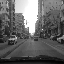

In [578]:
display(img)

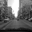

In [579]:
display(lowResImg)

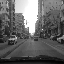

In [580]:
display(biCubicImg)

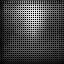

In [581]:
display(superResImg)